In [ ]:
#default_exp interpret.compare

# Compare Models

> This module offers functions to compare two or more models' predictions. More specifically, you can easily extract the filenames of the images that all your models agree on.

<br>
<br>

In [ ]:
#export
from fastai2.vision.all import *
from fastai2_extensions.interpret import *

In [ ]:
#hide
from torchvision.models import mobilenet_v2

path_data = Path('/Users/rahulsomani/Desktop/shot-lighting-cast')

dls1 = ImageDataLoaders.from_folder(path_data/'train', valid_pct=0.2, seed=42,
                                    item_tfms = Resize(size=224, method=ResizeMethod.Squish))
dls2 = ImageDataLoaders.from_folder(path_data/'train', valid_pct=0.15, seed=42,
                                    item_tfms = Resize(size=224, method=ResizeMethod.Squish))
dls3 = ImageDataLoaders.from_folder(path_data/'train', valid_pct=0.10, seed=42,
                                    item_tfms = Resize(size=224, method=ResizeMethod.Squish))



class ApplyPILFilter(RandTransform):pass
learn1 = load_learner(path_data/'fastai2-110-epoch-model.pkl');
learn1.dls = dls1

learn2 = load_learner(path_data/'fastai2-110-epoch-model.pkl');
learn2.dls = dls2

learn3 = load_learner(path_data/'fastai2-110-epoch-model.pkl');
learn3.dls = dls3


/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/rahulsomani/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by 

In [ ]:
#export
def intersection(sets:Collection):
    '`set.intersection` for a list of sets of any size'
    if len(sets) == 1: return sets
    res = sets[0]
    for x in sets[1:]: res=res.intersection(x)
    return res

In [ ]:
sets = [set(('a','b','c','e')), set(('a','b','c','d')), set(('c','d','e'))]
intersection(sets)

{'c'}

In [ ]:
#export
from matplotlib_venn import venn2, venn3

def compare_venn(interps:Collection,
                 conf_level:Union[int,float,tuple],
                 title=None, mode=('accurate','inaccurate'),
                 return_fig=False, return_common=True,
                 figsize=(10,6), set_color='tomato'):
    """
    Compute the agreement between 2 or more models' predictions
     
    If you only input 2-3 models in `interps`, then you also get
    a venn diagram to visualise the agreement between these models
    
    Key Arguments
    =============
    * interps:    a list or tuple of `ClassificationInterpretationEx` objects
    * mode:       either 'accurate' or 'inaccurate' to filter predictions
    * conf_level: a single number or a tuple of (min,max) to filter the prediction confidence
    """
    assert len(interps) > 1, 'Enter 2 or more models to compare'
    ### Extract fnames per model per label
    fnames_dict = defaultdict()
    for i,interp in enumerate(interps):
        name = f"interp{i+1}"
        fnames_dict[name] = {}.fromkeys(interp.dl.vocab)
        for label in fnames_dict[name].keys():
            fnames_dict[name][label] = interp.get_fnames(label, mode, conf_level)
    
    if len(interps) <= 3:
        ### Prepare sets of filenames per label for venn diagrams
        sets_dict = defaultdict(list)
        for interp in fnames_dict.values():
            for label,fnames in interp.items():
                sets_dict[label].append(set(fnames))

        ### Plot venn diagrams
        fig, axes = plt.subplots(nrows=1, ncols=interps[0].dl.c, figsize=figsize)
        for i,(label,sets) in enumerate(sets_dict.items()):
            set_labels = [f"Model {j+1}" for j in range(len(interps))]
            set_colors = [set_color] * len(interps)
            axes[i].set_title(label)
            if len(interps) == 2:
                venn2(sets, set_labels=set_labels, ax=axes[i], set_colors=set_colors)
            if len(interps) == 3:
                venn3(sets, set_labels=set_labels, ax=axes[i], set_colors=set_colors)

        ## Plot titles and subtitles
        if title is not None: fig.suptitle(title) 
        else:
            if isinstance(conf_level, tuple): filler = f'Between {conf_level[0]}-{conf_level[1]}'
            else:
                if mode == 'accurate': filler = f'Above {conf_level}'
                else:                  filler = f'Below {conf_level}'
            if mode == 'accurate':   fig.suptitle(f'Model Agreement - {mode.capitalize()} {filler} % Confidence')
            if mode == 'inaccurate': fig.suptitle(f'Model Agreement - {mode.capitalize()} {filler} % Confidence')
        plt.subplots_adjust(top = 1.1, bottom=0.01, hspace=0.25, wspace=0.1)
    else:
        fig=None
    
    if return_common:
        res_set = {label:intersection(sets_dict[label]) for label in interps[0].dl.vocab}

    if return_fig    and     return_common: return (fig, res_set)
    if return_fig    and not return_common: return fig
    if return_common and not return_fig:    return res_set

In [ ]:
interp1 = ClassificationInterpretationEx.from_learner(learn1)
interp2 = ClassificationInterpretationEx.from_learner(learn2)
interp3 = ClassificationInterpretationEx.from_learner(learn3)
interp1.compute_label_confidence()
interp2.compute_label_confidence()
interp3.compute_label_confidence()

In [ ]:
%%capture
fig,common_labels = compare_venn(
    conf_level=(0,99),  interps=[interp1,interp2],
    mode='accurate',
    return_common=True, return_fig=True,
    set_color='tomato'
)

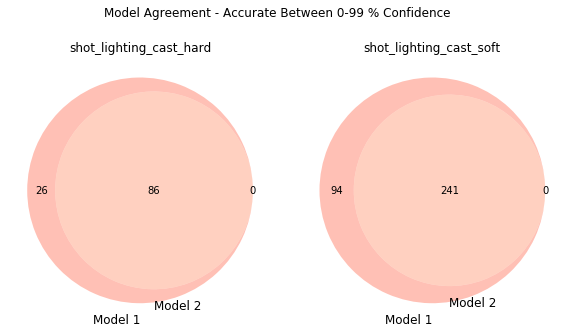

In [ ]:
fig

In [ ]:
common_labels.keys()

dict_keys(['shot_lighting_cast_hard', 'shot_lighting_cast_soft'])

In [ ]:
print(len(common_labels['shot_lighting_cast_hard']))
print(len(common_labels['shot_lighting_cast_soft']))

23
185


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01-classification-interpretation.ipynb.
Converted 02-compare-models.ipynb.
Converted index.ipynb.
